In [1]:
import os
import datetime
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.optim as optim
import cv2
import dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [2]:
# Variables
DATASET_DIR = "../MIT_split/"
LABELS_DICT = {"Opencountry":0 ,  "coast":1,   "forest":2, "highway":3, "inside_city":4,  "mountain":5 , "street":6,  "tallbuilding":7}
MODEL_FNAME = 'model.h5'
BATCH_SIZE = 16
EPOCHS = 20
INPUT_SIZE = 64
EXPERIMENTS_PATH = 'experiments'


In [3]:
# check for CUDA availability
if torch.cuda.is_available():
    print('CUDA is available, setting device to CUDA')
# set device to  CUDA for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available, setting device to CUDA


In [4]:
##Instantiate Tensorboard Writer
#Create log folders
train_logdir = os.path.join(EXPERIMENTS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'train')
val_logdir = os.path.join(EXPERIMENTS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'validation')
#Create summary writer
train_writer = SummaryWriter(log_dir=train_logdir)
val_writer = SummaryWriter(log_dir=val_logdir)


In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader, test_loader = dataset.get_dataloaders(DATASET_DIR, INPUT_SIZE, BATCH_SIZE, kwargs)

In [6]:
len(train_loader)

118

In [7]:
# Set up the network and training parameters

from losses import ContrastiveLoss
import torchvision.models as models
margin = 1.

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 8)
cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [17]:
model.layer2[-2].conv1

Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [8]:
from train import fit
fit(train_loader, test_loader, model, criterion, optimizer, scheduler, EPOCHS, cuda, log_interval)


/home/marcelo/miniconda3/envs/T3-M1/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 2.209230
Train: [300/1881 (85%)]	Loss: 1.269814
Epoch: 1/20. Train set: Average loss: 1.2312
Epoch: 1/20. Validation set: Average loss: 0.7066
Train: [0/1881 (0%)]	Loss: 0.545609
Train: [300/1881 (85%)]	Loss: 0.927446
Epoch: 2/20. Train set: Average loss: 0.9023
Epoch: 2/20. Validation set: Average loss: 0.7581
Train: [0/1881 (0%)]	Loss: 0.795593
Train: [300/1881 (85%)]	Loss: 0.873201
Epoch: 3/20. Train set: Average loss: 0.8563
Epoch: 3/20. Validation set: Average loss: 0.5219
Train: [0/1881 (0%)]	Loss: 0.819032
Train: [300/1881 (85%)]	Loss: 0.729109
Epoch: 4/20. Train set: Average loss: 0.7456
Epoch: 4/20. Validation set: Average loss: 0.5502
Train: [0/1881 (0%)]	Loss: 0.655305
Train: [300/1881 (85%)]	Loss: 0.597104
Epoch: 5/20. Train set: Average loss: 0.6142
Epoch: 5/20. Validation set: Average loss: 2.7544
Train: [0/1881 (0%)]	Loss: 0.435501
Train: [300/1881 (85%)]	Loss: 0.595900
Epoch: 6/20. Train set: Average loss: 0.6014
Epoch: 6/20. Validation set: A

score obtained equal to 0.9107806691449815


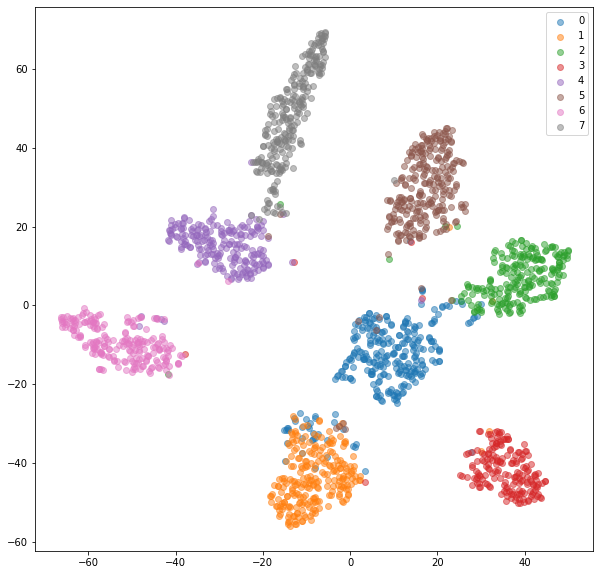

In [9]:
%matplotlib inline
from plot_emb import plot_embeddings, extract_embeddings
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model,layer_lvl=2):
    model_cut = nn.Sequential(*list(model.children())[:-layer_lvl])
    with torch.no_grad():        
        model.eval()
        embeddings = np.empty((0,2048))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            #print(images.shape)
            #print(model(images.float()).shape)
            #print(model_cut(images.float()).data.cpu().numpy().shape)
            embeddings = np.vstack((embeddings,model_cut(images.float()).data.cpu().numpy().reshape(-1,2048)))
            #print(embeddings.shape)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels
def fit_retrival(embeddings,labels,mode='knn'):
    if mode == 'knn':
        clf = neighbors.KNeighborsClassifier(n_neighbors=8)
        clf.fit(embeddings, labels)
    return clf
def predict_retrival(model,embeddings,labels):
    return model.predict(embeddings),model.score(embeddings,labels)
def plot_TSNE(embeddings):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2,
                 init='random').fit_transform(embeddings)
    return  X_embedded

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)

TSNE_embedding = plot_TSNE(train_embeddings_otl)
retrival_module = fit_retrival(train_embeddings_otl,train_labels_otl,mode='knn')

plot_embeddings(TSNE_embedding, train_labels_otl)


test_embeddings_otl, test_labels_otl = extract_embeddings(test_loader, model)
labels,score = predict_retrival(retrival_module,test_embeddings_otl, test_labels_otl)
print('score obtained equal to {}'.format(score))

In [41]:
def precision_recall_curve(X,Y,module):
    from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)
    from sklearn import preprocessing
    predictions = module.predict(X)
    y_score = module.predict_proba(X)
    precision = dict()
    clf = preprocessing.LabelBinarizer()
    clf.fit(Y)
    Y = clf.transform(Y)
    recall = dict()
    for i in range(8):
        precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

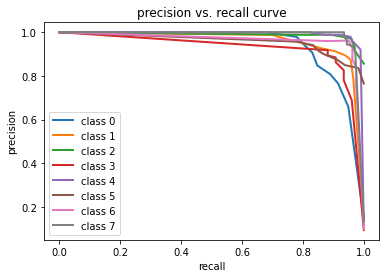

In [42]:
precision_recall_curve(test_embeddings_otl, test_labels_otl,retrival_module)

In [40]:
test_labels_otl

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [19]:
!python -m pip install scikit-learn --upgrade
